# Overall description
This notbook is almost the same as the U-net and the U-net has more clear explanation.<br>
Please start with the U-net notbook!

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from PIL import Image
import random
from pathlib import Path
import time

# Pair the data image and label image together

In [5]:
def get_paired_npy_files(data_folder: str, label_folder: str) -> list[tuple[Path, Path]]:
    """
    Pair .npy data and label files by matching their full IDs like:
    '0247_magnitudeFFT_slice1.npy' <-> '0247_protonDensity_slice1.npy'
    """
    def get_file_key(path: Path) -> str:
        # Remove suffix, e.g. '.npy'
        stem = path.stem  # e.g., "0247_magnitudeFFT_slice1"
        if 'magnitudeFFT' in stem:
            return stem.replace('magnitudeFFT', '')
        elif 'protonDensity' in stem:
            return stem.replace('protonDensity', '')
        else:
            return None  # not a valid key

    data_folder = Path(data_folder)
    label_folder = Path(label_folder)

    data_files = {get_file_key(f): f for f in data_folder.glob('*.npy') if get_file_key(f)}
    label_files = {get_file_key(f): f for f in label_folder.glob('*.npy') if get_file_key(f)}

    common_keys = sorted(set(data_files.keys()) & set(label_files.keys()))

    paired_files = [(data_files[k], label_files[k]) for k in common_keys]

    return paired_files


In [6]:
train_data_file_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/all_data"
train_label_file_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/all_label"

test_data_file_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256/test_folder/data"
test_label_file_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256/test_folder/label"

train_paired_files = get_paired_npy_files(train_data_file_path, train_label_file_path)

test_paired_files = get_paired_npy_files(test_data_file_path, test_label_file_path)

# Turn paired_files into full paths

In [7]:
from torch.utils.data import Dataset
import numpy as np

class DataLabelDataset(Dataset):
    def __init__(self, paired_files, transform=None):
        self.paired_files = paired_files
        self.transform = transform

    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        data_path, label_path = self.paired_files[idx]
        data = np.load(data_path)
        label = np.load(label_path)

        if self.transform:
            data = self.transform(data)
            label = self.transform(label)

        return data, label

# Visualize! Visualize! Visualize!



In [8]:
def visualize_dataset(dataset, num_samples=5):
    """
    Visualize a few (data, label) pairs from a given dataset.
    """
    plt.figure(figsize=(10, num_samples * 4))

    for i in range(num_samples):
        data, label = dataset[i]

        # In case the data and label are not 2D (e.g., 1D), you might need to reshape.
        if data.ndim > 2:
            data = data.squeeze()
        if label.ndim > 2:
            label = label.squeeze()

        # Plot data
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(data, cmap='gray')
        print(data.shape)
        plt.title(f'Data {i+1}')
        plt.axis('off')

        # Plot label
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(label, cmap='gray')
        print(label.shape)
        plt.title(f'Label {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
# Create dataset object
train_dataset = DataLabelDataset(train_paired_files)
print(len(train_paired_files))
test_dataset = DataLabelDataset(test_paired_files)
print(len(test_paired_files))

12374
34


train datasets
(256, 256)
(256, 256)
(256, 256)
(256, 256)


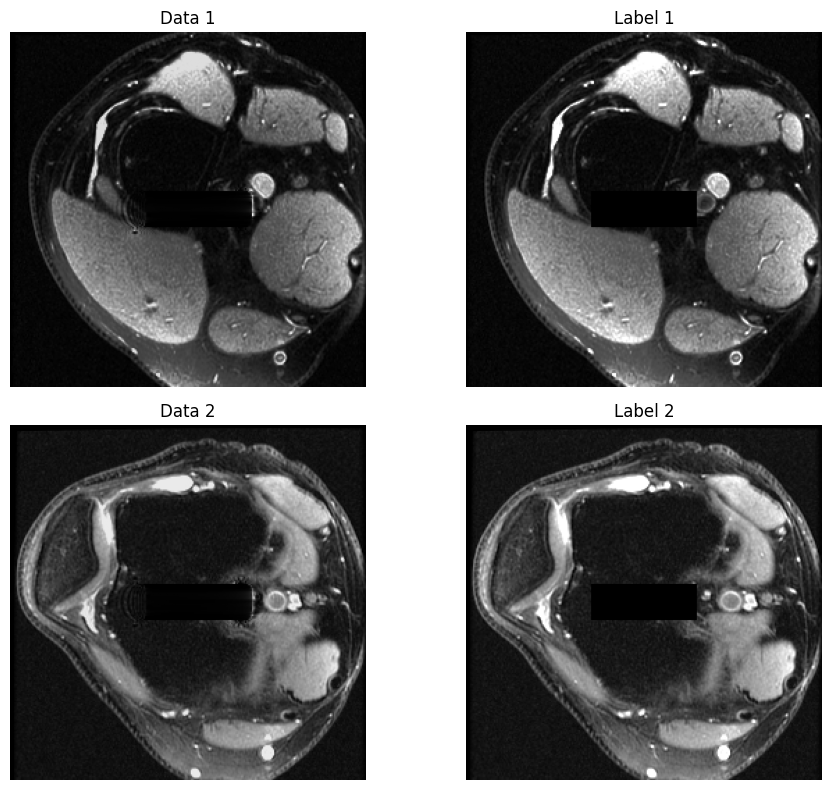

test datasets
(256, 256)
(256, 256)
(256, 256)
(256, 256)


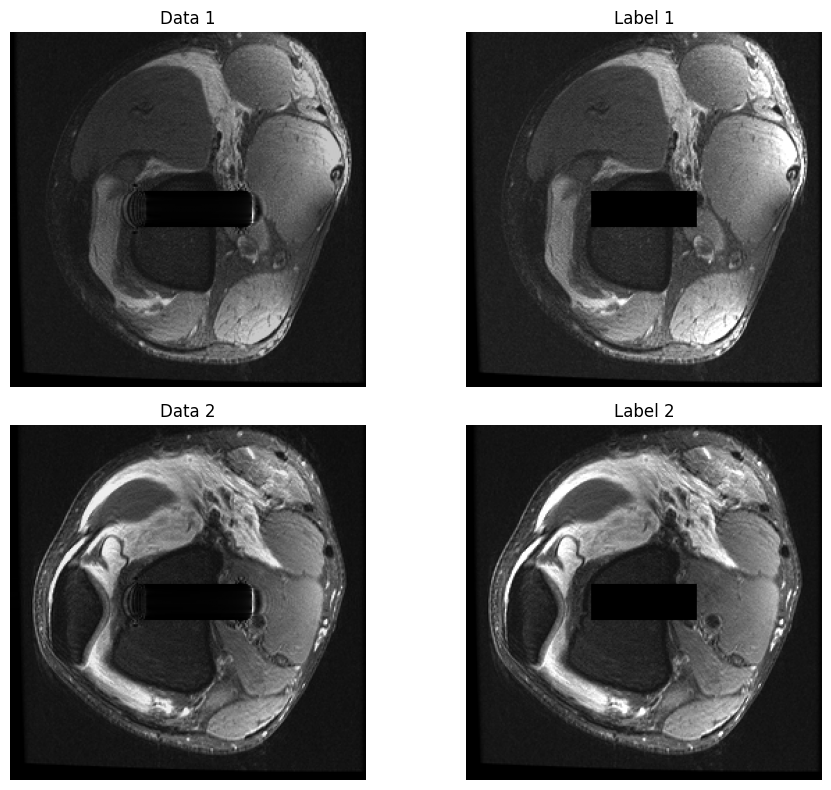

In [10]:
# Visualize 5 pairs
print("train datasets")
visualize_dataset(train_dataset, num_samples=2)
print("test datasets")
visualize_dataset(test_dataset, num_samples=2)

# Autoencoder

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()  # <--- important!

        input_dimension = 256 * 256
        output_dimension = 256 * 256

        self.encoder = nn.Sequential(
            nn.Linear(input_dimension, 512),
            nn.ReLU(),  # <--- add activations!
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_dimension)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [17]:
def train_autoencoder_dataloader(model, train_loader, test_loader,
                                 epochs=10, lr=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, label in train_loader:
            # Flatten inputs for fully connected autoencoder
            data = data.view(data.size(0), -1).to(device)
            label = label.view(label.size(0), -1).to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, label in test_loader:
                data = data.view(data.size(0), -1).to(device)
                label = label.view(label.size(0), -1).to(device)
                outputs = model(data)
                loss = loss_fn(outputs, label)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [18]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
start_time = time.time()

model = Autoencoder()  # your fully connected autoencoder
train_autoencoder_dataloader(model, train_loader, test_loader, epochs=10, lr=1e-4)

end_time = time.time()
elapsed_time = end_time-start_time

print(f"Training took {elapsed_time:.2f} seconds.")

Epoch 1/10 | Train Loss: 0.0270 | Val Loss: 0.0210
Epoch 2/10 | Train Loss: 0.0192 | Val Loss: 0.0181
Epoch 3/10 | Train Loss: 0.0172 | Val Loss: 0.0167
Epoch 4/10 | Train Loss: 0.0159 | Val Loss: 0.0158
Epoch 5/10 | Train Loss: 0.0151 | Val Loss: 0.0150
Epoch 6/10 | Train Loss: 0.0146 | Val Loss: 0.0145
Epoch 7/10 | Train Loss: 0.0142 | Val Loss: 0.0141
Epoch 8/10 | Train Loss: 0.0140 | Val Loss: 0.0139
Epoch 9/10 | Train Loss: 0.0137 | Val Loss: 0.0137
Epoch 10/10 | Train Loss: 0.0135 | Val Loss: 0.0134
Training took 740.95 seconds.


In [20]:
save_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project"
torch.save(model.state_dict(), save_path + "autoencoder.pt")

# Trying the model on the test folder

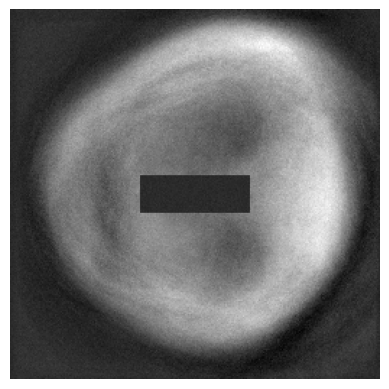

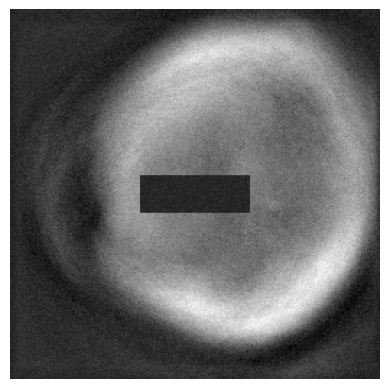

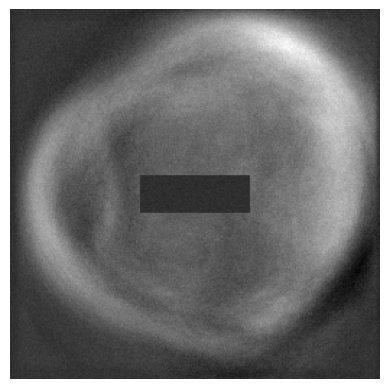

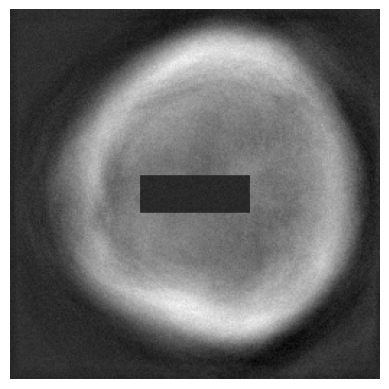

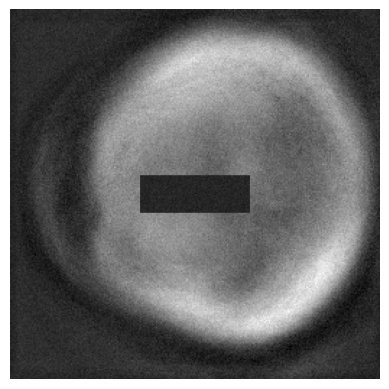

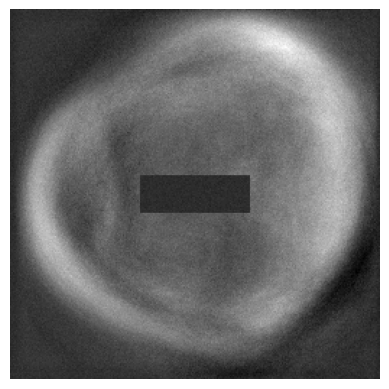

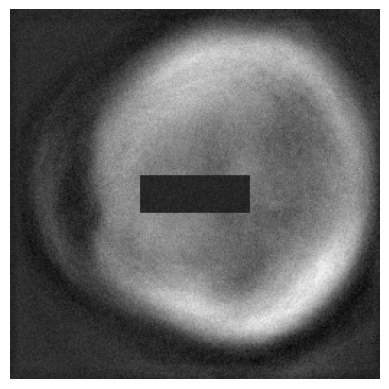

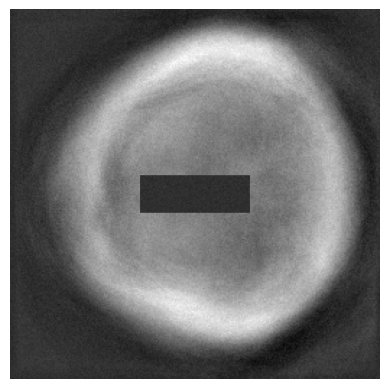

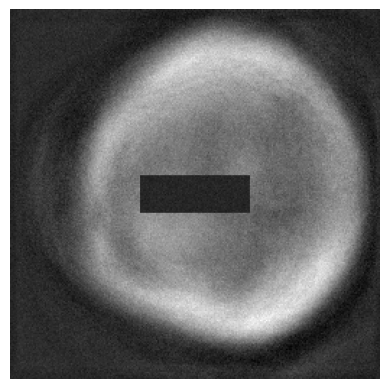

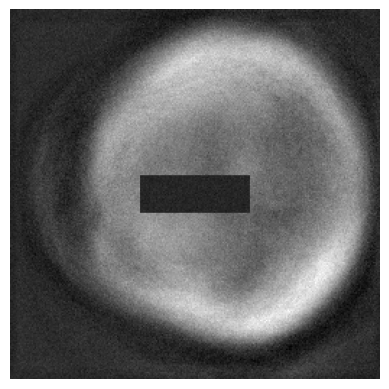

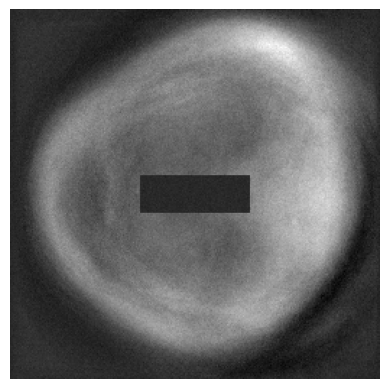

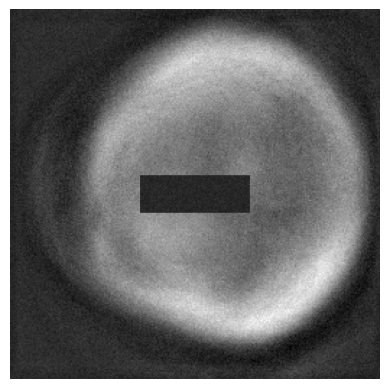

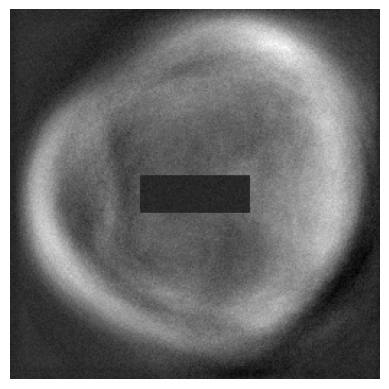

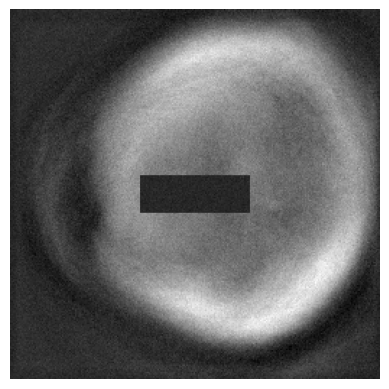

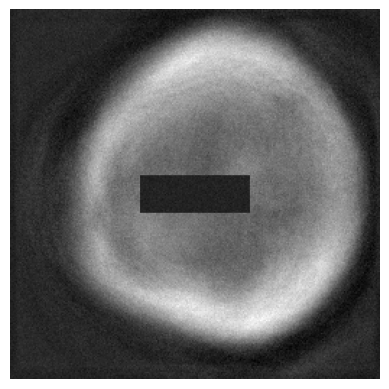

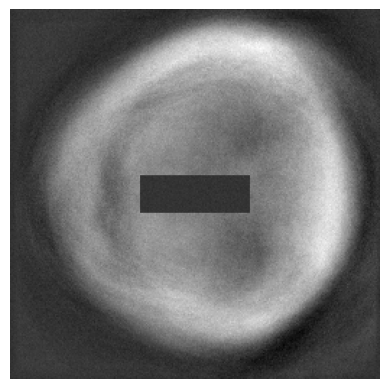

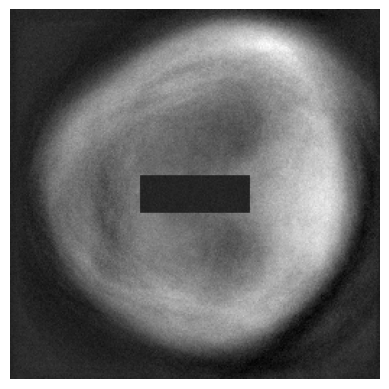

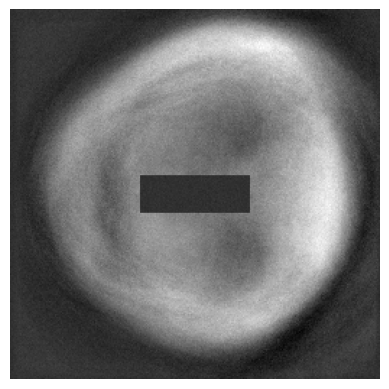

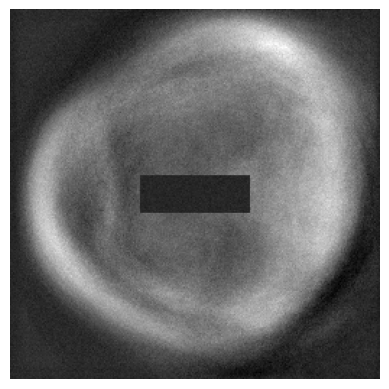

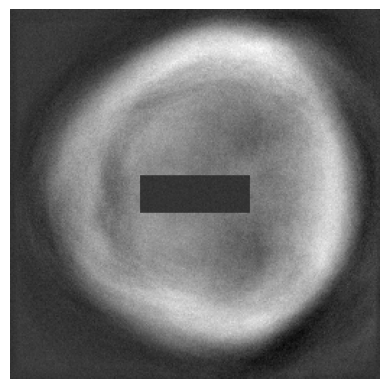

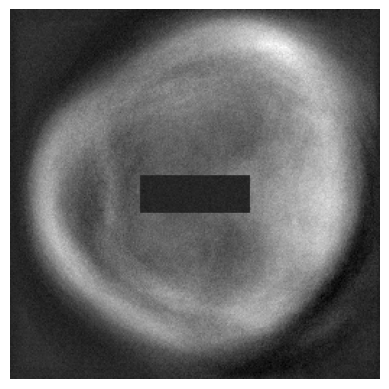

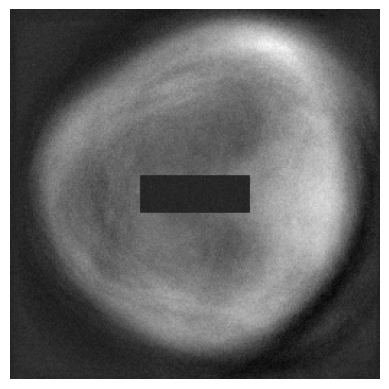

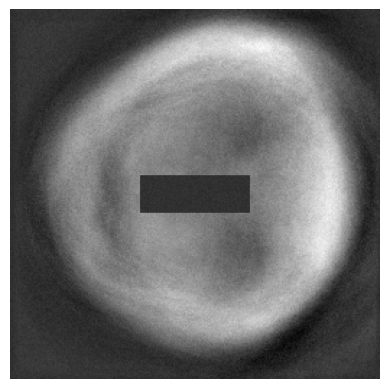

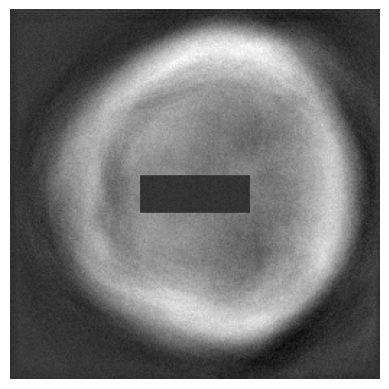

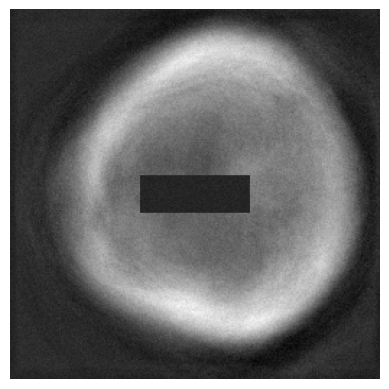

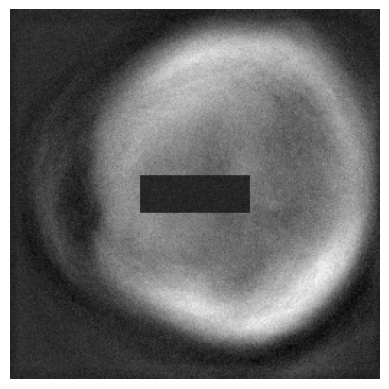

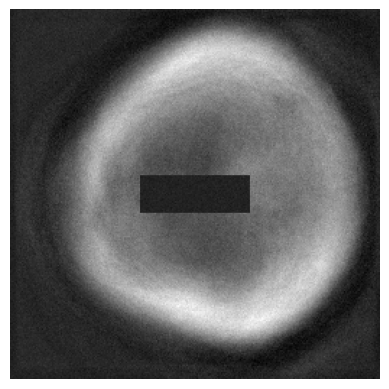

In [26]:
# https://code.adonline.id.au/structural-similarity-index-ssim-in-python/
from skimage.metrics import structural_similarity as ssim

device='cuda' if torch.cuda.is_available() else 'cpu'
test_folder = Path("/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256/real_test_folder/data")
label_folder = Path("/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256/real_test_folder/label")

x_cor = []
y_cor = []

for file in test_folder.iterdir():
  img = np.load(file)
  img_tensor = torch.tensor(img).view(img.shape[0], -1).to(device)
  output_again = model(img_tensor.reshape(1, -1))
  img_again = output_again.detach().cpu().numpy().reshape(256, 256)

  # This is the label image
  name = file.name.replace("magnitudeFFT", "protonDensity")
  label_path = label_folder/name
  label_img = np.load(label_path)

  # Collect SSIM x and y coordinate
  x_cor.append(ssim(label_img, img, data_range=label_img.max()-img.min()))
  y_cor.append(ssim(label_img, img_again, data_range=label_img.max()-img_again.min()))

  # VIsualize the output image
  plt.imshow(img_again, cmap='gray')
  plt.axis(False)
  plt.show()

# SSIM

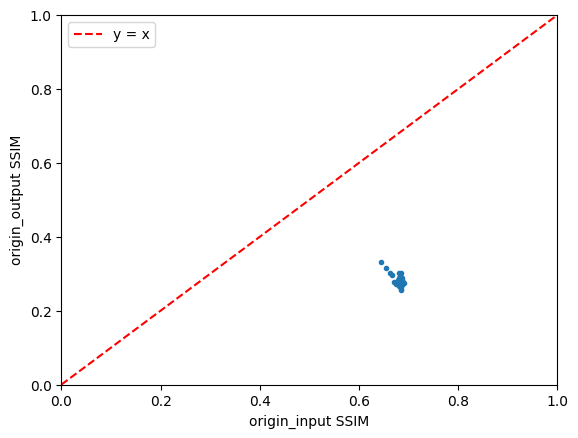

In [27]:
plt.scatter(x_cor,y_cor, marker='.')
plt.plot([0, 1], [0, 1], 'r--', label='y = x')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('origin_input SSIM')
plt.ylabel('origin_output SSIM')
plt.legend()
# plt.grid(True)
plt.show()